# Project
## BMES 547
### Matthew Falcione & Arun Balaji

### Import modules

In [1]:
%matplotlib inline
import sys, os
sys.path.append(os.environ['BMESAHMETDIR'])
import bmes

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, chi2

In [3]:
pd.options.display.max_columns = 50

### Download and load dataset

In [4]:
# retrieve file from url
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv"
data_file = bmes.downloadurl(url, 'risk_factors_cervical_cancer.csv');

In [5]:
# read in cervical cancer dataset
df = pd.read_csv(data_file)

### Clean data and replace missing values

* Covert all the columns that should be float or bool from string to their respective data types.

In [6]:
# after investigation, no information on 'Dx' could be found so it was dropped
df.drop(columns='Dx', axis=1, inplace=True)

# replace unknown values
df.replace('?', np.nan, inplace=True)

# define flaot columns from df
float_columns = ["Age", "Number of sexual partners", "First sexual intercourse",
                 "Num of pregnancies", "Smokes (years)", "Smokes (packs/year)",
                 "Hormonal Contraceptives (years)", "IUD (years)", "STDs (number)",
                 "STDs: Number of diagnosis",
                 "STDs: Time since first diagnosis", "STDs: Time since last diagnosis"]

# bool columns have binary values (1 or 0) so dtype set to bool
bool_columns = ['IUD', 'STDs', 'STDs:condylomatosis','STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
                'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                'STDs:genital herpes','STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV','STDs:Hepatitis B',
                'STDs:HPV','Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy',
                'Hormonal Contraceptives', "Smokes"]

**Missing value logic**
* if `STDs: Number of diagnosis` is 0, set each boolean STD-related column to False and each float STD-related column to 0
* drop samples with missing smoking-related attribute values (13 samples total)
* drop samples with missing Hormonal Contraceptives-related or IUD-related attribute values (115 samples total)
* for the remaining float attibute columns with missing values, replace with their respective median values

In [7]:
def replace_missing_values(df, float_columns, bool_columns):
    # set all value to float to handle numbers with str formatting
    df = df.astype(float)
    
    # STD-related boolean type attribute columns
    std_bool_columns = ['STDs', 'STDs:condylomatosis','STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
                        'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                        'STDs:genital herpes','STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV','STDs:Hepatitis B',
                        'STDs:HPV']
    # STD-related float type attribute columns
    std_float_columns = ["STDs (number)", "STDs: Time since first diagnosis", "STDs: Time since last diagnosis"]

    # loop through each row in the DataFrame
    for index, row in df.iterrows():
        # if STDs: Number of diagnosis is 0 set each boolean STD-related column to False and each float STD-related column to 0
        if row["STDs: Number of diagnosis"] == 0:
            df.loc[index, std_bool_columns] = False
            df.loc[index, std_float_columns] = 0

    # drop samples with missing smoking-related attribute values (13 samples total)
    df.dropna(subset=['Smokes (years)'], inplace=True)

    # drop samples with missing Hormonal Contraceptives-related or IUD-related attribute values (115 samples total)
    df.dropna(subset=['Hormonal Contraceptives (years)', 'IUD (years)'], inplace=True)

    # for the remaining float attibute columns with missing values, replace with their respective median values
    for col in float_columns:
        df[col] = df[col].fillna(df[col].median())    
        
    # update boolean column datatypes
    bool_type_dict = {col:bool for col in bool_columns}
    # set boolean column values to bool
    df = df.astype(bool_type_dict)   

    # replace all False with 0 and True with 1
    df.replace(False, 0, inplace=True)
    df.replace(True, 1, inplace=True)
    
    return df

In [8]:
# clean initial DataFrame and replace missing values
df = replace_missing_values(df, float_columns, bool_columns)

In [9]:
# extract class target values, attribute values, and attribute names
biopsy_series = df['Biopsy']
screening_test_series = df[['Hinselmann', 'Schiller', 'Citology']]
Y = df['Biopsy'].values
X = df.loc[:, df.columns != 'Biopsy'].values
names = df.loc[:, df.columns != 'Biopsy'].columns.tolist()

In [10]:
# remove target class from boolean column list
bool_columns.remove('Biopsy')

### Data Visualization - Clustering

t-distributed Stochastic Neighbor Embedding (TSNE) is a tool for projecting high dimensional data into a low-space while preserving the inter-sample distance seen at the higher dimensional space. This is particularly useful for determining which samples are "similar" and which are different.

This sections uses the `TSNE` class of the `sklearn.manifold` module to project the cervical cancer risk factor data into two dimensions and creates a scatter plot of the resulting projection.

#### t-SNE by Screening Test
A t-SNE visualation was created for the top 3 most correlated attributes from the preliminary analysis on the dataset (the screening tests - `Hinselmann`, `Schiller`, `Citology`) and the class target value (`Biopsy`). 

In [11]:
# create t-SNE model to extract 2 dimensions of the embedded space (X)
tsne = TSNE(n_components=2, verbose=True, perplexity=30, n_iter=5000, random_state=0)
# fit model to X
tsne_results = tsne.fit_transform(X)

# create DataFrame from 2 dimensions of the embedded space
tsne_df = pd.DataFrame(data=tsne_results, columns=['tsne 1', 'tsne 2'])

# concatentate the class labels with the t_SNE results DataFrame
tsne_with_class_label_df = pd.concat([tsne_df, screening_test_series, biopsy_series], axis=1)

# replace all 0 with 'False' and 1 with 'True'
tsne_with_class_label_df.replace(0, 'False', inplace=True)
tsne_with_class_label_df.replace(1, 'True', inplace=True)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 730 samples in 0.001s...
[t-SNE] Computed neighbors for 730 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 730 / 730
[t-SNE] Mean sigma: 1.807549
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.697426
[t-SNE] KL divergence after 3300 iterations: 0.702865


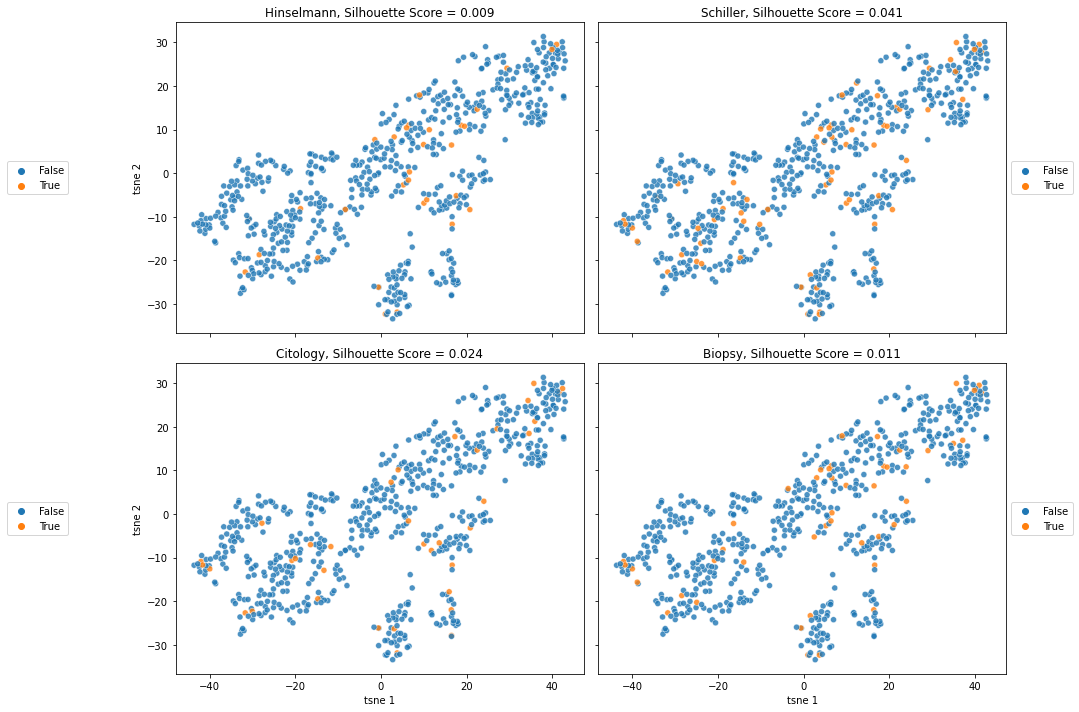

In [12]:
# create t-SNE dimension scatterplot colored by class label
fig, axes = plt.subplots(2, 2, figsize = (15, 10), sharex=True, sharey=True)

s1 = sns.scatterplot(data=tsne_with_class_label_df, x='tsne 1', y='tsne 2',
                alpha=0.8, ax=axes[0,0], hue='Hinselmann')

s2 = sns.scatterplot(data=tsne_with_class_label_df, x='tsne 1', y='tsne 2',
                alpha=0.8, ax=axes[0,1], hue='Schiller')

s3 = sns.scatterplot(data=tsne_with_class_label_df, x='tsne 1', y='tsne 2',
                alpha=0.8, ax=axes[1,0], hue='Citology')

s4 = sns.scatterplot(data=tsne_with_class_label_df, x='tsne 1', y='tsne 2',
                alpha=0.8, ax=axes[1,1], hue='Biopsy')

axes[0,0].set_title(f'Hinselmann, Silhouette Score = {silhouette_score(tsne_df.values, screening_test_series["Hinselmann"]):.3f}')
axes[0,1].set_title(f'Schiller, Silhouette Score = {silhouette_score(tsne_df.values, screening_test_series["Schiller"]):.3f}')
axes[1,0].set_title(f'Citology, Silhouette Score = {silhouette_score(tsne_df.values, screening_test_series["Citology"]):.3f}')
axes[1,1].set_title(f'Biopsy, Silhouette Score = {silhouette_score(tsne_df.values, biopsy_series):.3f}')

s2.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
s1.legend(loc='center right', bbox_to_anchor=(-0.25, 0.5), ncol=1)
s3.legend(loc='center right', bbox_to_anchor=(-0.25, 0.5), ncol=1)
s4.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

fig.tight_layout()

**Figure 1:** A t-SNE visualization was created for the top 3 most correlated attributes from the preliminary analysis on the dataset (the screening tests - Hinselmann, Schiller, Citology) and the class target value (Biopsy). There is no discernable patterns or splits in the data for any of the screening tests or the class target value, meaning there are likely multiple factors needed to make an accurate prediction of the target value.

### Create repeated stratified k-fold cross-validation generator

In [13]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)

### Tree-based feature selection (embedded method)

In [14]:
# create random forest classifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

# fit the model to X and Y
rf_model.fit(X, Y)

RandomForestClassifier(random_state=0)

In [15]:
# get the feature importances
importances = rf_model.feature_importances_

# get the top 10 most important attributes from X
importances_series = pd.Series(importances, index=names)
top_n_most_important_attributes = importances_series.nlargest(10).index.tolist()

# get the column numbers of X from the top 10 most important features
attribute_column_numbers = [names.index(attribute) for attribute in top_n_most_important_attributes]

# extract 10 most important features from X
X_most_important = X[:, attribute_column_numbers]

In [16]:
# print 10 most important attibutes selected by the model
print('10 most important features:')
print('---------------------------')
for i, attribute in enumerate(top_n_most_important_attributes):
    print(f'{i+1}. {attribute}')

10 most important features:
---------------------------
1. Schiller
2. Hinselmann
3. Age
4. Hormonal Contraceptives (years)
5. First sexual intercourse
6. Citology
7. Number of sexual partners
8. Num of pregnancies
9. Smokes (years)
10. Dx:CIN


### Univariate Feature Selection (filter method)

In [17]:
# apply SelectKBest class to extract top 10 best features using a chi^2 distribution
k = 10
best_features = SelectKBest(score_func=chi2, k=k)

# fit the feature selction to the X values
X_k_best = best_features.fit_transform(X, Y)

In [18]:
# extract k best attrobite scores (a score is given for all attributes)
df_scores = pd.DataFrame(best_features.scores_)
# create DataFrame of attribute names
df_columns = pd.DataFrame(names)

# combine attribute names and scores from k best into DataFrame and rename columns
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Specs', 'Score']

In [19]:
# print top 10 attributes and k best scores
print('Top 10 attributes and k-best scores:')
print('------------------------------------')
print(feature_scores.nlargest(k, 'Score'))

Top 10 attributes and k-best scores:
------------------------------------
                              Specs       Score
32                         Schiller  353.674831
31                       Hinselmann  199.711268
33                         Citology   77.635002
5                    Smokes (years)   51.967208
8   Hormonal Contraceptives (years)   43.009505
30                           Dx:HPV   22.925323
28                        Dx:Cancer   20.963675
12                    STDs (number)   13.688781
19              STDs:genital herpes   13.313725
27  STDs: Time since last diagnosis   11.478385


### Create Classification Evaluation Metric Function

In [20]:
def classification_evaluation_metrics(model, X, Y, cv, classifciation_type):
    # generate predicted Y values from 10 fold stratified k-fold cross-validation
    Y_pred = cross_val_predict(model, X, Y, cv=10)

    # create confusion matrix from Y and predicted Y values
    cm = confusion_matrix(Y, Y_pred)
    # extract true positive, false negative, false positive, and true negative from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    
    # create confusion matrix plot with Cancer and No Cancer labels
    fig, ax = plt.subplots(1, 1)
    confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Cancer','Cancer'])
    confusion_matrix_display.plot(ax=ax)
    _ = ax.set_title(f'{classifciation_type} Biopsy Confusion Matrix')
    
    # print out evaluation mertics for model
    # each calculation is an average across all cross-validation sets
    print('Average metrics across all cross-validation sets:')
    print(f'TNR (Specificity): {tn/(fp+tn):0.2}')
    print(f'TPR (Sensitivity/Recall): {tp/(fn+tp):0.2}')
    print(f'PPV (Precision): {tp/(fp+tp):0.2}')
    print(f'Error Rate: {(fp + fn)/(fp+tp+tn+fn):0.2}')
    print(f'Accuracy: {(tp + tn)/(fp+tp+tn+fn):0.2}')
    
    # calculate F1 score from model
    n_scores = cross_val_score(model, X, Y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
    print(f'F1 Score: {np.mean(n_scores):0.2}')
    # calculate AUC-ROC value from model
    n_scores = cross_val_score(model, X, Y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    print(f'AUC-ROC: {np.mean(n_scores):0.2}')

### Classification - Random Forest 

Random Forest model was previously created and fit to the data in the tree-based feature selection section.

#### K-best selected features

Average metrics across all cross-validation sets:
TNR (Specificity): 0.97
TPR (Sensitivity/Recall): 0.55
PPV (Precision): 0.58
Error Rate: 0.059
Accuracy: 0.94
F1 Score: 0.63
AUC-ROC: 0.93


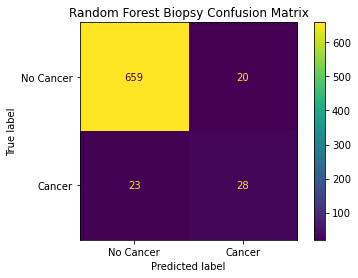

In [21]:
# run classification evaluation metrics function for Random Forest classification using 10 k-best X attibutes
classification_evaluation_metrics(model=rf_model, X=X_k_best, Y=Y, cv=cv, classifciation_type='Random Forest')

**Figure 2:** A confusion matrix of the predicted and true cancer labels of the biopsy target variable using the univariate random forest method. 659 samples were true negative, 20 samples were false negative, 23 samples were false positive, and 28 samples were true positive.

#### Tree-based selected features

Average metrics across all cross-validation sets:
TNR (Specificity): 0.98
TPR (Sensitivity/Recall): 0.57
PPV (Precision): 0.64
Error Rate: 0.052
Accuracy: 0.95
F1 Score: 0.63
AUC-ROC: 0.95


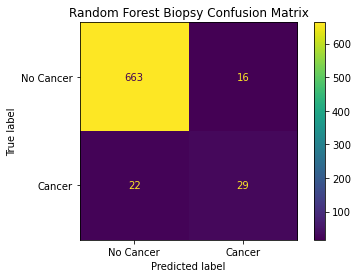

In [22]:
# run classification evaluation metrics function for Random Forest classification
# using 10 most important X attibutes from the tree-based feature selection
classification_evaluation_metrics(model=rf_model, X=X_most_important, Y=Y, cv=cv, classifciation_type='Random Forest')

**Figure 3:** A confusion matrix of the predicted and true cancer labels of the biopsy target variable using the tree-based random forest method. 663 samples were true negative, 16 samples were false negative, 22 samples were false positive, and 29 samples were true positive.

### Classification - XGBoost

In [23]:
# initiate XGBoost classifier model
xgboost_model = XGBClassifier()

#### K-best selected features

Average metrics across all cross-validation sets:
TNR (Specificity): 0.97
TPR (Sensitivity/Recall): 0.59
PPV (Precision): 0.6
Error Rate: 0.056
Accuracy: 0.94
F1 Score: 0.63
AUC-ROC: 0.93


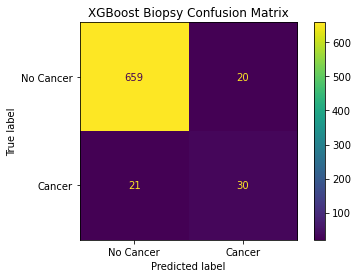

In [24]:
# run classification evaluation metrics function for XGBoost classification using 10 k-best X attibutes
classification_evaluation_metrics(model=xgboost_model, X=X_k_best, Y=Y, cv=cv, classifciation_type='XGBoost')

**Figure 4:** A confusion matrix of the predicted and true cancer labels of the biopsy target variable using the univariate XGBoost method. 659 samples were true negative, 20 samples were false negative, 21 samples were false positive, and 30 samples were true positive.

#### Tree-based selected features

Average metrics across all cross-validation sets:
TNR (Specificity): 0.97
TPR (Sensitivity/Recall): 0.71
PPV (Precision): 0.67
Error Rate: 0.045
Accuracy: 0.95
F1 Score: 0.64
AUC-ROC: 0.95


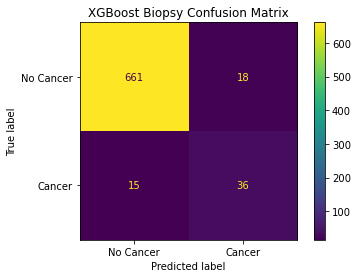

In [25]:
# run classification evaluation metrics function for XGBoost classification
# using 10 most important X attibutes from the tree-based feature selection
classification_evaluation_metrics(model=xgboost_model, X=X_most_important, Y=Y, cv=cv, classifciation_type='XGBoost')

**Figure 5:** A confusion matrix of the predicted and true cancer labels of the biopsy target variable using the tree-based XGBoost method. 661 samples were true negative, 18 samples were false negative, 15 samples were false positive, and 36 samples were true positive.

### Classification - Neural Network

In [26]:
# control how many hidden units are used for the network
NUM_HIDDEN = 5

In [27]:
# initiate neural network classifier model
nn_model = MLPClassifier(solver='adam', hidden_layer_sizes=(NUM_HIDDEN,), random_state=0, max_iter=1000)

#### K-best selected features

Average metrics across all cross-validation sets:
TNR (Specificity): 0.98
TPR (Sensitivity/Recall): 0.59
PPV (Precision): 0.73
Error Rate: 0.044
Accuracy: 0.96
F1 Score: 0.65
AUC-ROC: 0.91


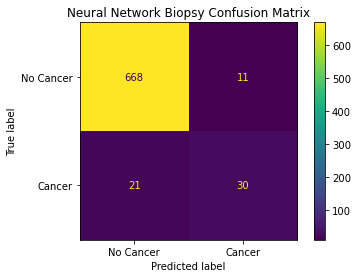

In [28]:
# run classification evaluation metrics function for neural network classification using 10 k-best X attibutes
classification_evaluation_metrics(model=nn_model, X=X_k_best, Y=Y, cv=cv, classifciation_type='Neural Network')

**Figure 6:** A confusion matrix of the predicted and true cancer labels of the biopsy target variable using the univariate neural network method. 668 samples were true negative, 11 samples were false negative, 21 samples were false positive, and 30 samples were true positive.

#### Tree-based selected features

Average metrics across all cross-validation sets:
TNR (Specificity): 0.98
TPR (Sensitivity/Recall): 0.59
PPV (Precision): 0.7
Error Rate: 0.047
Accuracy: 0.95
F1 Score: 0.62
AUC-ROC: 0.94


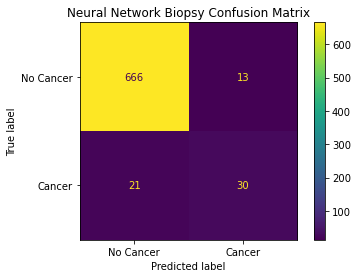

In [29]:
# run classification evaluation metrics function for neural network classification
# using 10 most important X attibutes from the tree-based feature selection
classification_evaluation_metrics(model=nn_model, X=X_most_important, Y=Y, cv=cv, classifciation_type='Neural Network')

**Figure 7:** A confusion matrix of the predicted and true cancer labels of the biopsy target variable using the tree-based neural network method. 666 samples were true negative, 13 samples were false negative, 21 samples were false positive, and 30 samples were true positive.